In [1]:
import feather
import scanpy as sc
import numpy as np
import scanpy as sc
import pandas as pd
from anndata import AnnData
import anndata

In [2]:
import matplotlib.pyplot as plt
from pylab import rcParams
rcParams['figure.figsize'] = 15,10

In [3]:
#read in normalized gene expression matrix
msn_nuclei = feather.read_dataframe("../data/processed/msn_nuclei.feather")

In [6]:
#read in annoation matrix
msn_annot = pd.read_csv("../data/processed/msn_nuclei_annotation.csv",index_col=0)

In [7]:
msn_annot.head()

,cell_id,nUMIs,nGenes,doublet_score,region,full_id,precluster,size_factor
X,,,,,,,,
caudate_AAACCCAGTGGACCAA,AAACCCAGTGGACCAA,123667,7963,0.195725,caudate,caudate_AAACCCAGTGGACCAA,7,2.516823
caudate_AAACGAATCTGGGAGA,AAACGAATCTGGGAGA,52628,5692,0.267317,caudate,caudate_AAACGAATCTGGGAGA,2,1.117240
caudate_AAACGAATCTTGGAAC,AAACGAATCTTGGAAC,105720,7612,0.357998,caudate,caudate_AAACGAATCTTGGAAC,7,2.232862
caudate_AAAGAACTCCCGTTGT,AAAGAACTCCCGTTGT,48878,4953,0.102173,caudate,caudate_AAAGAACTCCCGTTGT,2,1.017234
caudate_AAAGGATTCGTTCTAT,AAAGGATTCGTTCTAT,84923,6590,0.460791,caudate,caudate_AAAGGATTCGTTCTAT,7,1.769039


In [11]:
#convert gene expression matrix into annoated dataframe
msn_ann = AnnData(msn_nuclei)
msn_ann.obs_names = msn_annot["full_id"].values
msn_ann.obs["nUMIs"] = msn_annot["nUMIs"].values
msn_ann.obs["nGenes"] = msn_annot["nGenes"].values

msn_ann.obs["region"] = pd.Categorical(msn_annot["region"].values,np.unique(msn_annot["region"].values))

msn_ann.obs["doublet_score"] = msn_annot["doublet_score"].values
msn_ann.obs["size_factor"] = msn_annot["size_factor"].values

Transforming to str index.


In [14]:
sc.pp.highly_variable_genes(msn_ann, n_top_genes=4500)
sc.pp.pca(msn_ann, use_highly_variable=True)
sc.pp.neighbors(msn_ann)
sc.tl.umap(msn_ann)

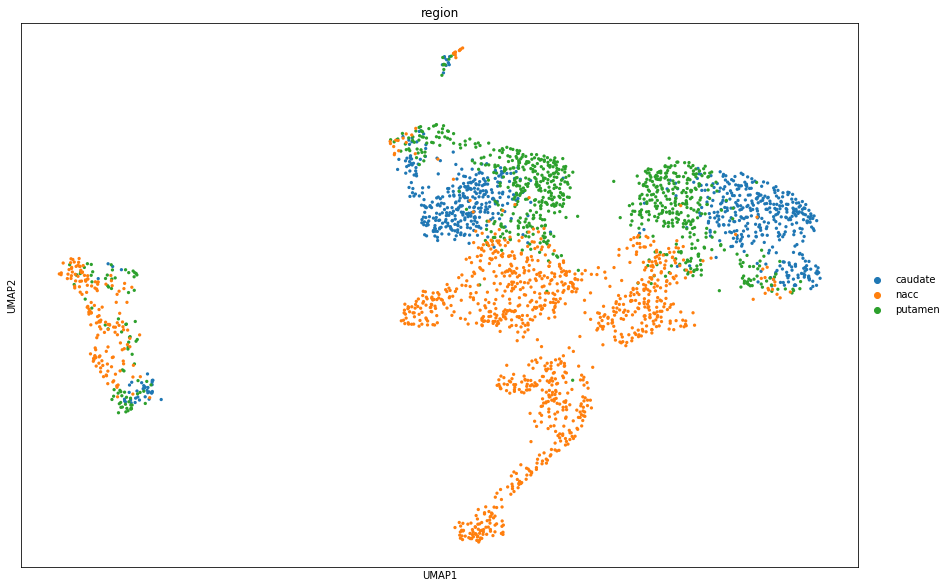

In [15]:
#looking at the region distribution there seem to be some strong Nacc regional effects
sc.pl.umap(msn_ann,color="region")

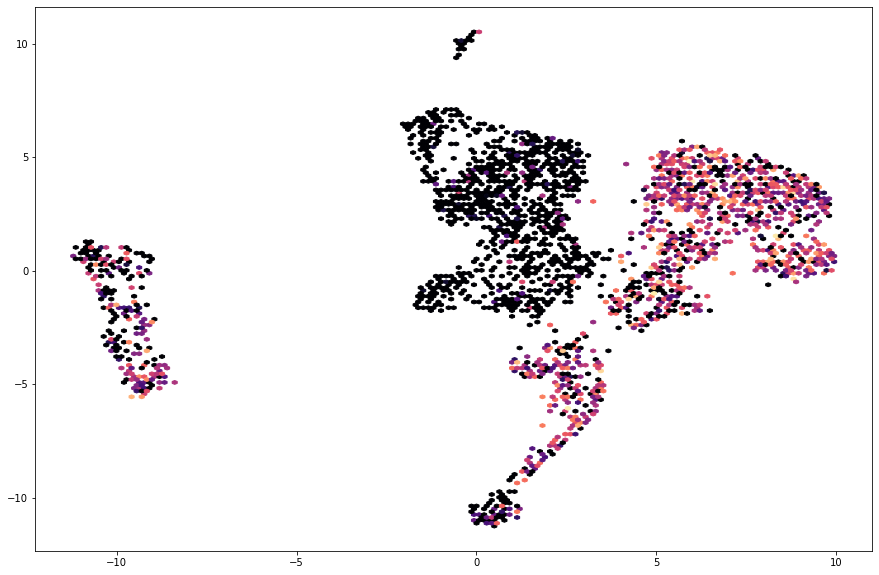

In [21]:
#D1 cell type marker 
plt.hexbin(x=msn_ann.obsm["X_umap"][:,0],y=msn_ann.obsm["X_umap"][:,1],C=msn_ann.obs_vector("DRD1"),gridsize=150,cmap="magma")

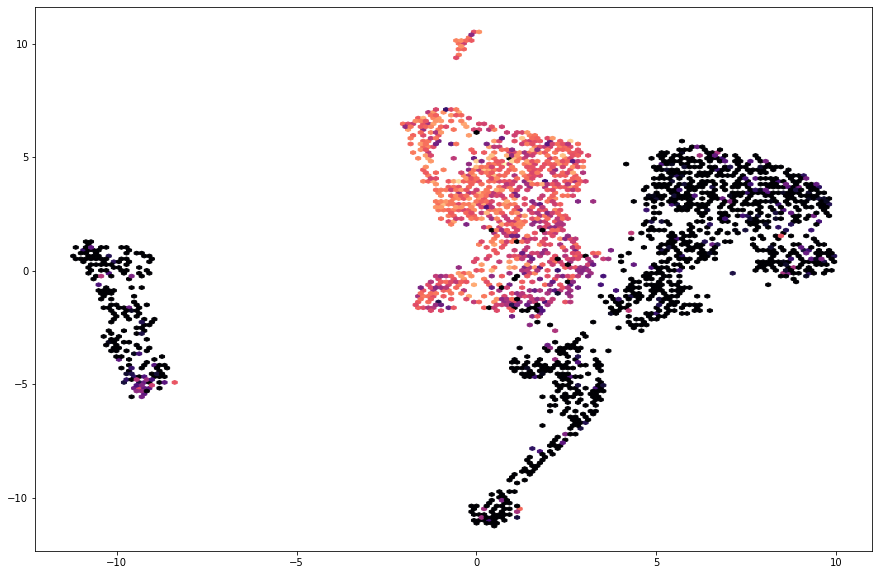

In [22]:
#D2 cell type marker 
plt.hexbin(x=msn_ann.obsm["X_umap"][:,0],y=msn_ann.obsm["X_umap"][:,1],C=msn_ann.obs_vector("DRD2"),gridsize=150,cmap="magma")

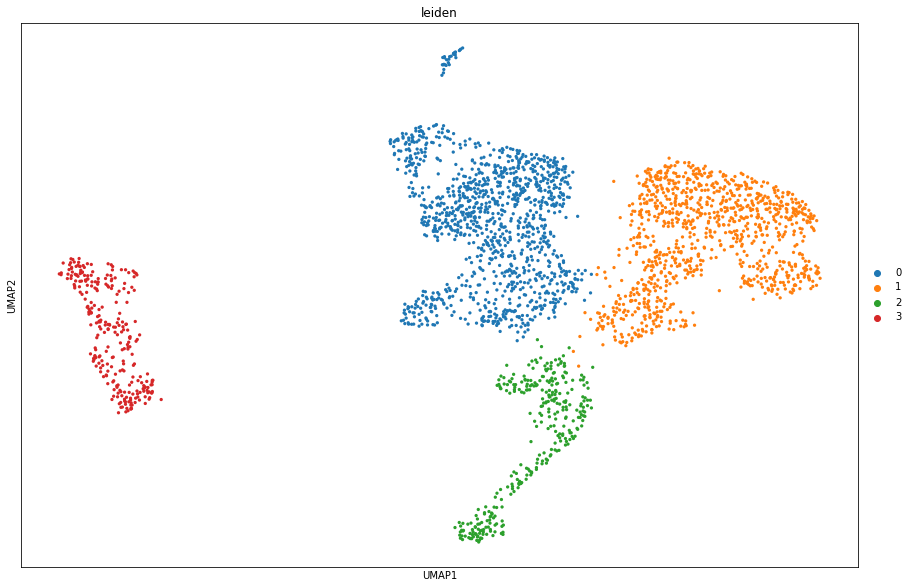

In [18]:
sc.tl.leiden(msn_ann,resolution=0.05)
sc.pl.umap(msn_ann,color="leiden")

In [23]:
#hiearchally cluster our nuclie
sc.tl.dendrogram(msn_ann,groupby="leiden")

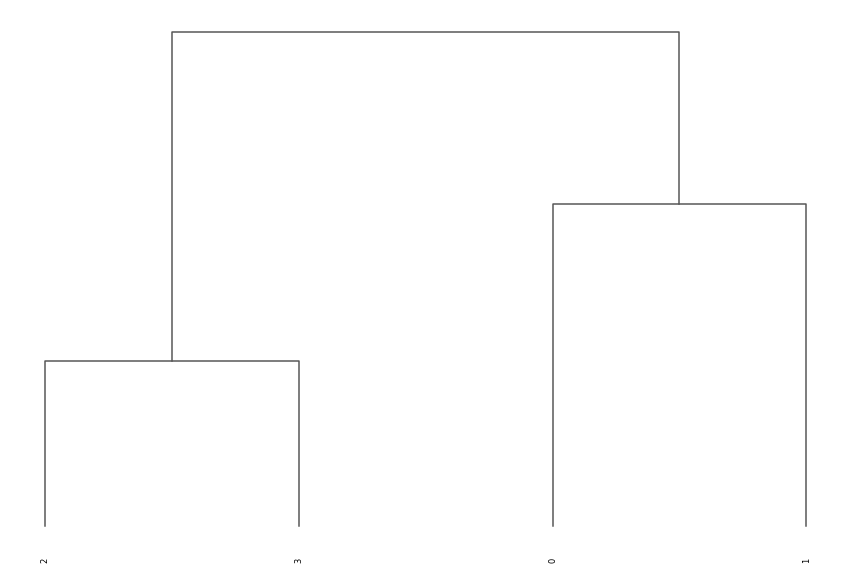

In [25]:
#the Nacc enriched clusters seem to cluster together before the other retions
sc.pl.dendrogram(msn_ann,groupby="leiden")

In [26]:
msn_ann.X.shape

(2791, 53573)

In [27]:
#We are now going to make a distance heatmap for our 4 clusters using cosine distance in pca space
pca_sorted = msn_ann.obsm["X_pca"][np.argsort(msn_ann.obs["leiden"].values),:]

In [29]:
from scipy.spatial.distance import pdist, squareform
pca_dist_heatmap = 1.0-squareform(pdist(pca_sorted,metric="cosine"))

In [36]:
from collections import Counter
clust_count =Counter(msn_ann.obs["leiden"].values)
clust_count

Counter({'0': 1192, '1': 1001, '3': 275, '2': 323})

In [38]:
#we randomly select equal numbers of nuclei per cluster
selection = np.concatenate([np.random.choice(np.arange(0,clust_count["0"]),200),
                            np.random.choice(np.arange(clust_count["0"],clust_count["0"]+clust_count["1"]),200), 
                            np.random.choice(np.arange(clust_count["0"]+clust_count["1"],
                                                       clust_count["0"]+clust_count["1"]+clust_count["2"]),200), 
                            np.random.choice(np.arange(clust_count["0"]+clust_count["1"]+clust_count["2"],
                                                       clust_count["0"]+clust_count["1"]+clust_count["2"]+
                                                       clust_count["3"]),200)])

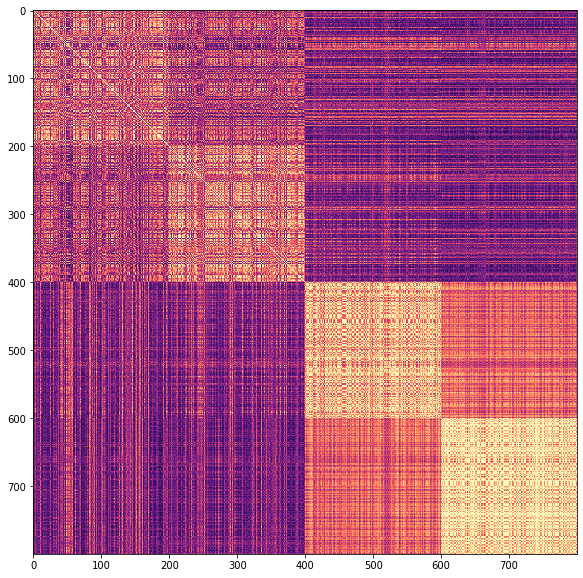

In [39]:
plt.imshow(pca_dist_heatmap[selection,:][:,selection],cmap="magma",vmax=0.6)

In [40]:
#looking at the top marker genes for each cluster
is_mark = [ctype == "0" for ctype in msn_ann.obs["leiden"].values]
msn_ann.obs["mark"] = pd.Categorical(
            values=is_mark,
            categories=[True, False])
sc.tl.rank_genes_groups(msn_ann, "mark")
gene_list = [tup[0] for tup in msn_ann.uns["rank_genes_groups"]["names"]]
print("Cluster 0 Marker genes")
print(gene_list[:20])

is_mark = [ctype == "1" for ctype in msn_ann.obs["leiden"].values]
msn_ann.obs["mark"] = pd.Categorical(
            values=is_mark,
            categories=[True, False])
sc.tl.rank_genes_groups(msn_ann, "mark")
gene_list = [tup[0] for tup in msn_ann.uns["rank_genes_groups"]["names"]]
print("Cluster 1 Marker genes")
print(gene_list[:20])

is_mark = [ctype == "2" for ctype in msn_ann.obs["leiden"].values]
msn_ann.obs["mark"] = pd.Categorical(
            values=is_mark,
            categories=[True, False])
sc.tl.rank_genes_groups(msn_ann, "mark")
gene_list = [tup[0] for tup in msn_ann.uns["rank_genes_groups"]["names"]]
print("Cluster 2 Marker genes")
print(gene_list[:20])

is_mark = [ctype == "3" for ctype in msn_ann.obs["leiden"].values]
msn_ann.obs["mark"] = pd.Categorical(
            values=is_mark,
            categories=[True, False])
sc.tl.rank_genes_groups(msn_ann, "mark")
gene_list = [tup[0] for tup in msn_ann.uns["rank_genes_groups"]["names"]]
print("Cluster 3 Marker genes")
print(gene_list[:20])

Cluster 0 Marker genes
['DRD2', 'PTPRM', 'CHRM3', 'FIG4', 'GRIK3', 'PENK', 'HS3ST4', 'SMOC2', 'ADORA2A-AS1', 'TTC12', 'GUCY1A1', 'RABGAP1L', 'ANKK1', 'ANKRD13A', 'COCH', 'PTPRR', 'UNC5D', 'NETO2', 'FAM135B', 'GUCY1A2']
Cluster 1 Marker genes
['RELN', 'EBF1', 'DSCAM', 'CNR1', 'LINC01951', 'DRD1', 'AC106741.1', 'AC109466.1', 'SLC35F3', 'AC008415.1', 'ROBO2', 'ASAP2', 'DOCK4', 'RGS6', 'CCDC88C', 'RASGEF1B', 'IQCJ-SCHIP1', 'SORCS1', 'TAC1', 'HS6ST3']
Cluster 2 Marker genes
['MYO16', 'FOXP2', 'FSTL4', 'TIAM1', 'GRM1', 'SEZ6L', 'CPNE4', 'ARHGAP6', 'SGCD', 'CUX2', 'KCNJ3', 'FAM155A', 'TCERG1L', 'ERBB4', 'ENOX1', 'GREB1L', 'NTN1', 'NHS', 'KCNT2', 'SOX1-OT']
Cluster 3 Marker genes
['RXFP1', 'FOXP2', 'ERBB4', 'GALNTL6', 'TSHZ1', 'EYA2', 'FAM155A', 'PPM1E', 'SEMA5B', 'ADARB2', 'HS6ST2', 'KIRREL1', 'GNG4', 'KHDRBS3', 'NRXN1', 'ALK', 'TRHDE', 'KCNT2', 'SOX2-OT', 'PLXDC2']


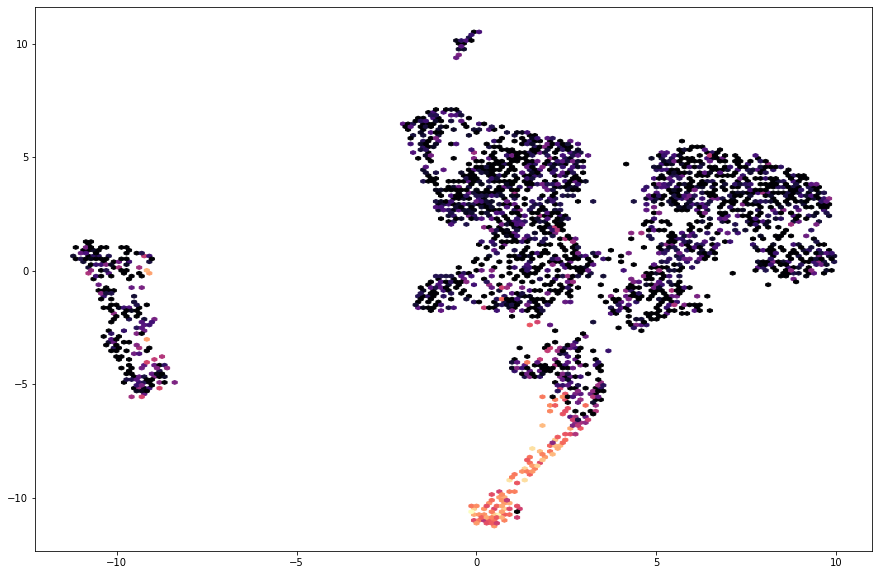

In [41]:
#Cluster 2 cell type marker 
plt.hexbin(x=msn_ann.obsm["X_umap"][:,0],y=msn_ann.obsm["X_umap"][:,1],C=msn_ann.obs_vector("CPNE4"),gridsize=150,cmap="magma")

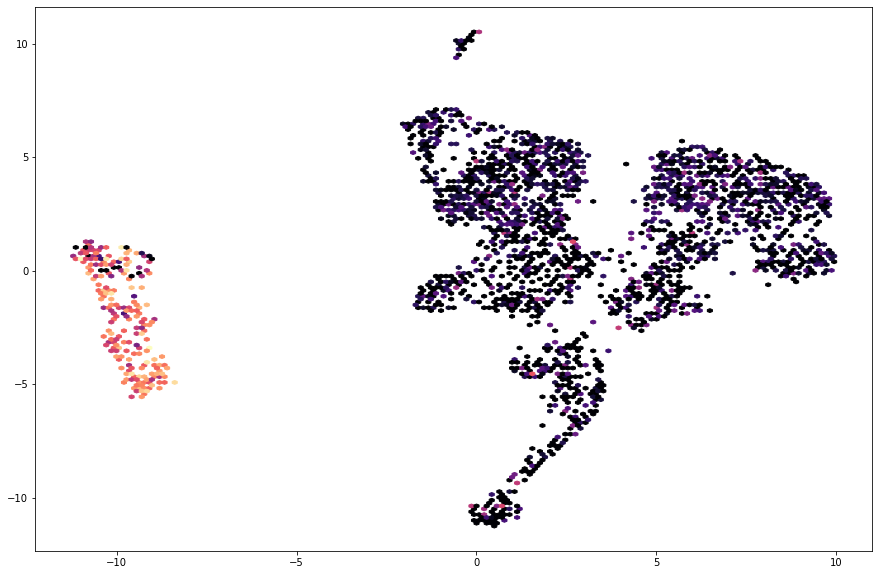

In [42]:
#Cluster 3 cell type marker 
plt.hexbin(x=msn_ann.obsm["X_umap"][:,0],y=msn_ann.obsm["X_umap"][:,1],C=msn_ann.obs_vector("RXFP1"),gridsize=150,cmap="magma")

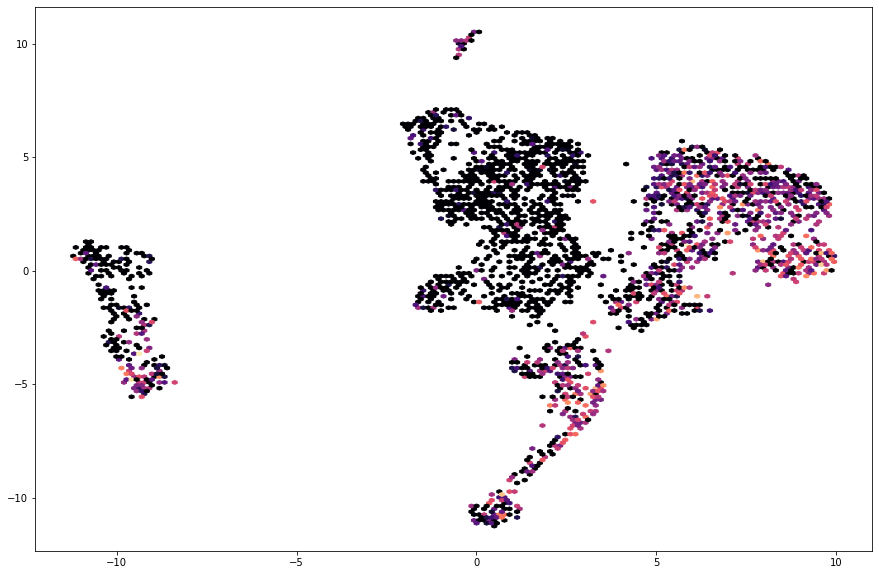

In [43]:
#Other D1 cell marker
plt.hexbin(x=msn_ann.obsm["X_umap"][:,0],y=msn_ann.obsm["X_umap"][:,1],C=msn_ann.obs_vector("TAC1"),gridsize=150,cmap="magma")

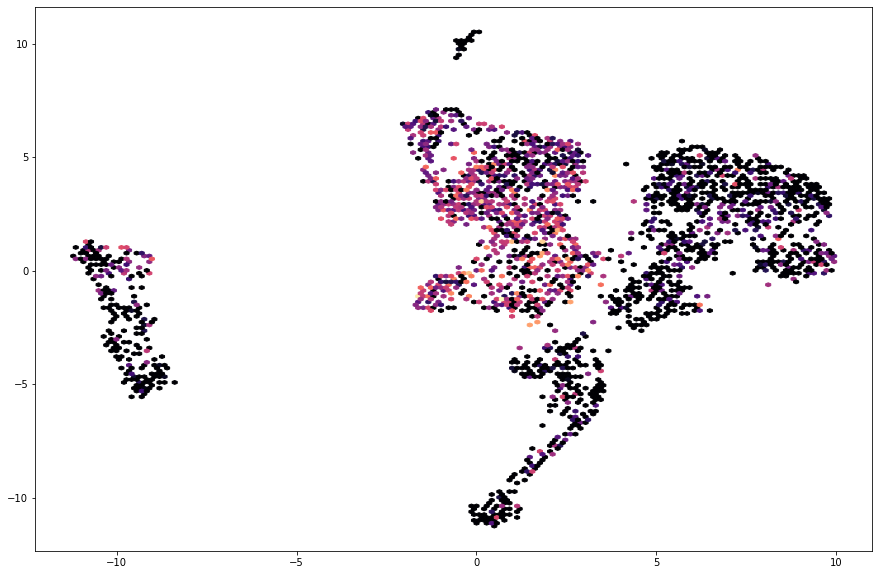

In [44]:
#Other D2 cell marker
plt.hexbin(x=msn_ann.obsm["X_umap"][:,0],y=msn_ann.obsm["X_umap"][:,1],C=msn_ann.obs_vector("PENK"),gridsize=150,cmap="magma")

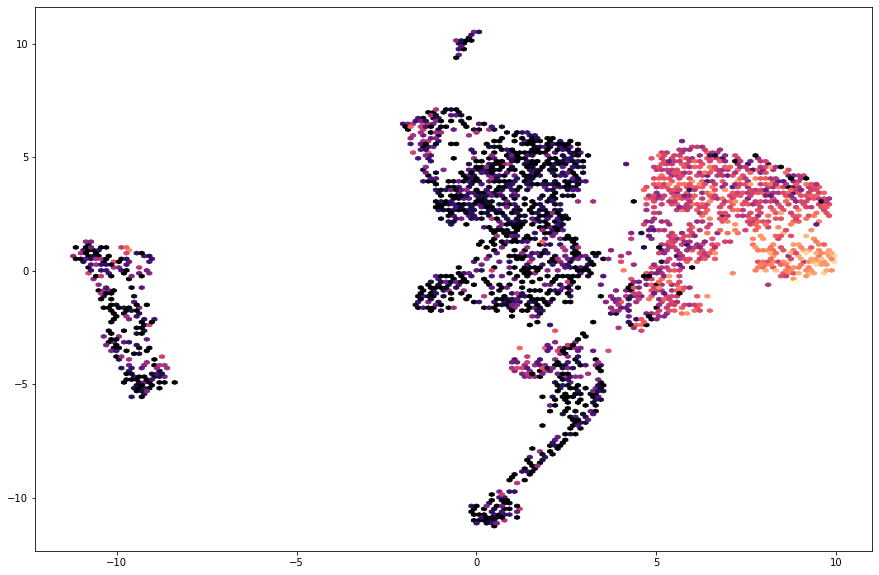

In [45]:
#Marker for cluster 1
plt.hexbin(x=msn_ann.obsm["X_umap"][:,0],y=msn_ann.obsm["X_umap"][:,1],C=msn_ann.obs_vector("RELN"),gridsize=150,cmap="magma")

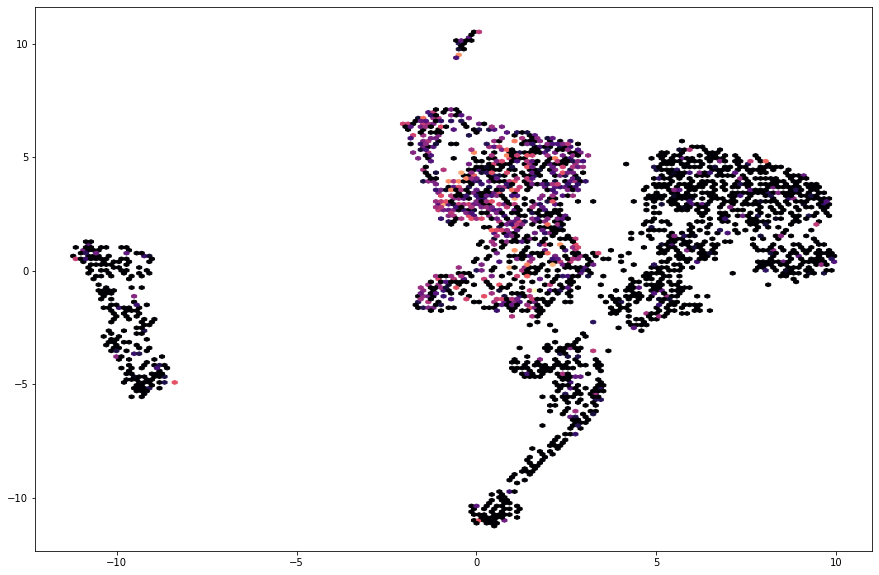

In [46]:
#Adora2a marker
plt.hexbin(x=msn_ann.obsm["X_umap"][:,0],y=msn_ann.obsm["X_umap"][:,1],C=msn_ann.obs_vector("ADORA2A-AS1"),gridsize=150,cmap="magma")

In [47]:
#lets relabel the clusters as cell types
cluster_assign_dict = {"0":"D2-Major","1":"D1-Major","2":"D1-CPNE4","3":"D1-RXFP1"}
cell_type_vec = np.asarray([cluster_assign_dict[clust] for clust in msn_ann.obs["leiden"].values])

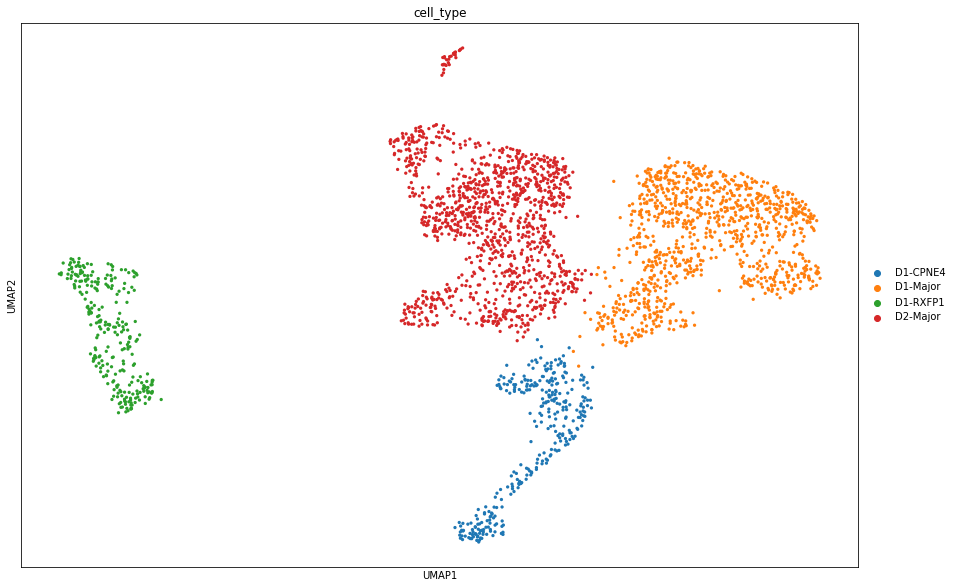

In [49]:
msn_ann.obs["cell_type"] = pd.Categorical(cell_type_vec,np.unique(cell_type_vec))
sc.pl.umap(msn_ann,color="cell_type")

In [50]:
#add cell types to the annoation and save the new file
msn_annot["cell_type"] = cell_type_vec 
msn_annot.to_csv("../data/processed/msn_labeled_nuclei_annotation.csv")

In [51]:
#save the new anndata object
msn_ann.write("../data/processed/msn_labeled_nuclei.h5ad")